In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
import sys
from statsmodels.formula.api import ols
from IPython.display import clear_output
from numba import njit, jit

In [2]:
df = pd.read_csv('SALES_2019.csv', parse_dates=['Date'])

In [3]:
df

,SKU_ID,Store_ID,Date,Demand,Regular_Price
0,114,1078,2019-01-01,2.0,51.0
1,114,1078,2019-01-02,2.0,51.0
2,114,1078,2019-01-03,2.0,51.0
3,114,1078,2019-01-04,2.0,51.0
4,114,1078,2019-01-05,2.0,51.0
...,...,...,...,...,...
75549757,363971,2866,2019-12-25,2.0,104.0
75549758,363971,2866,2019-12-26,2.0,104.0
75549759,363971,2866,2019-12-27,2.0,104.0
75549760,363971,2866,2019-12-28,2.0,104.0


<AxesSubplot:xlabel='Date'>

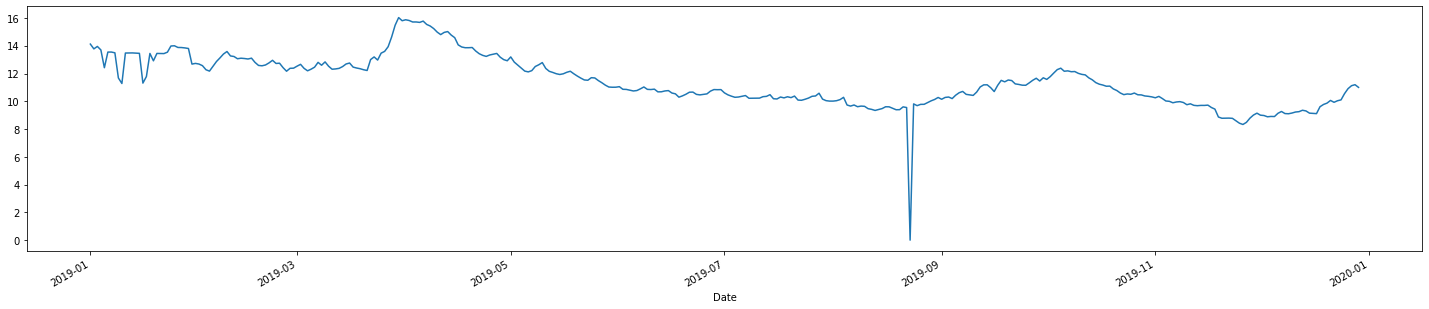

In [4]:
df.groupby('Date').mean()['Demand'].plot(figsize=(25, 5))

In [5]:
df = df[df.Demand > 0]
df

,SKU_ID,Store_ID,Date,Demand,Regular_Price
0,114,1078,2019-01-01,2.0,51.0
1,114,1078,2019-01-02,2.0,51.0
2,114,1078,2019-01-03,2.0,51.0
3,114,1078,2019-01-04,2.0,51.0
4,114,1078,2019-01-05,2.0,51.0
...,...,...,...,...,...
75549757,363971,2866,2019-12-25,2.0,104.0
75549758,363971,2866,2019-12-26,2.0,104.0
75549759,363971,2866,2019-12-27,2.0,104.0
75549760,363971,2866,2019-12-28,2.0,104.0


In [6]:
popular_pairs = df.groupby(['SKU_ID', 'Store_ID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [7]:
popular_pairs.head(n=10)

,SKU_ID,Store_ID,counts
0,121403,2834,361
1,14408,2834,361
2,150862,2834,361
3,213851,2834,361
4,93788,2834,361
5,137749,1855,361
6,149856,2676,361
7,93788,2711,361
8,4240,1498,361
9,93788,2710,361


In [15]:
popular_pairs.head(n=170000).tail(n=1)

,SKU_ID,Store_ID,counts
169999,312283,1200,298


In [17]:
num_of_pairs = 170000
pairs_for_experiment = [0 for _ in range(num_of_pairs)]
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment[i] = (r['SKU_ID'], r['Store_ID'])

In [18]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [19]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [20]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [21]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [22]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [24]:
def GeneratePEDModels(dataset):
    model_type = 'log-log'
    sku_id, store_id, elas, qty, ttpvalue, price, q1_elas = [], [], [], [], [], [], []
    q1_ttp = []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.Store_ID == shop_id) & (dataset.SKU_ID == good_id)]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

        sku_id.append(good_id)
        store_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        
        # 2019 Q1
        data = data[(data.Date >= '2019-01-01') & (data.Date <= '2019-03-31')]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)
        
        qty.append(data.Demand.sum() / data.shape[0])
        price.append(data.Regular_Price.sum() / data.shape[0])
        q1_elas.append(e)
        q1_ttp.append(tp)
        
        clear_output()
        print(iter_count)
        iter_count += 1
        
        if iter_count == 170000:
            break
    
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Elasticity': elas,
        'P_value': ttpvalue,
        'Q1_Qty': qty,
        'Q1_Price': price,
        'Q1_Elasticity': q1_elas,
        'Q1_Ttest': q1_ttp
    })

In [25]:
trained_data = GeneratePEDModels(df)

169999


In [26]:
trained_data

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest
0,121403,2834,4.947777e+00,1.387119e-91,203.211111,219.056926,2.499524e-01,4.107512e-01
1,14408,2834,-1.248910e+00,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08
2,150862,2834,-1.006074e+00,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14
3,213851,2834,-1.328601e+00,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01
4,93788,2834,1.314355e+00,9.124566e-86,206.511111,495.959667,1.156394e+00,1.298470e-08
...,...,...,...,...,...,...,...,...
169995,133782,1128,2.052770e-01,2.969268e-01,5.769231,78.000000,4.364594e-01,2.061059e-65
169996,96408,1841,-3.365364e-15,9.120910e-01,1.000000,626.093023,-2.220446e-16,9.963391e-01
169997,135276,1100,-3.331585e-01,7.131638e-02,1.327273,147.000000,1.652611e-01,1.021838e-36
169998,127511,1164,3.537239e+00,1.791653e-06,3.470588,277.602941,-2.765752e+01,3.684603e-04


In [27]:
trained_data.to_csv('DF_TRAIN_170K.csv', index=False)

# Train/test constructing

In [2]:
trained_data = pd.read_csv('DF_TRAIN_170K.csv')

In [3]:
df_train = trained_data[(trained_data.Elasticity > -10) & (trained_data.Elasticity < 0) & (trained_data.P_value < 0.05)]

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79710 entries, 1 to 169994
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SKU            79710 non-null  int64  
 1   Store          79710 non-null  int64  
 2   Elasticity     79710 non-null  float64
 3   P_value        79710 non-null  float64
 4   Q1_Qty         79710 non-null  float64
 5   Q1_Price       79710 non-null  float64
 6   Q1_Elasticity  79710 non-null  float64
 7   Q1_Ttest       79710 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 5.5 MB


In [5]:
product_info = pd.read_csv('PRODUCT_INF.csv')

In [6]:
product_info

,ProductName,SKU,ClassId,GroupId,SubGroupId,CategoryId,ClusterId,Class,Groups,SubGroups,Category,Cluster
0,UN,9999999,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
1,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122139,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
2,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122140,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
3,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122141,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
4,Очки_x0020_корригирующие_x0020_Dali_x0020_плас...,122142,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
...,...,...,...,...,...,...,...,...,...,...,...,...
296388,Лактамил_x0020_смесь_x0020_сухая_x0020_молочна...,112785,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296389,Чай_x0020__x0022_Хипп_x0022__x0020_с_x0020_вит...,112789,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296390,Чай_x0020_Хипп_x0020_био_x0020_для_x0020_корм....,76810,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296391,Фемилак_x0020_для_x0020_беременных_x0020_и_x00...,75619,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам


In [7]:
product_info = product_info[['SKU', 'ClassId', 'CategoryId', 'ClusterId', 'GroupId', 'SubGroupId']]

In [8]:
df_sku = df_train.join(product_info.set_index('SKU'), on='SKU')

In [9]:
df_sku.isna().sum()

SKU                0
Store              0
Elasticity         0
P_value            0
Q1_Qty             0
Q1_Price           0
Q1_Elasticity      0
Q1_Ttest           0
ClassId          238
CategoryId       238
ClusterId        238
GroupId          238
SubGroupId       238
dtype: int64

In [10]:
df_sku.dropna(inplace=True)

In [11]:
df_sku.isna().sum()

SKU              0
Store            0
Elasticity       0
P_value          0
Q1_Qty           0
Q1_Price         0
Q1_Elasticity    0
Q1_Ttest         0
ClassId          0
CategoryId       0
ClusterId        0
GroupId          0
SubGroupId       0
dtype: int64

In [12]:
df_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId
1,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003.0,2561.0,27.0,2047.0,2356.0
2,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003.0,2547.0,4.0,2047.0,2099.0
3,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003.0,2496.0,456.0,2037.0,2105.0
6,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003.0,3023.0,458.0,2037.0,2105.0
8,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003.0,2692.0,455.0,2037.0,2105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169985,127510,1121,-7.771024,2.630867e-33,1.563636,640.000000,1.426084e-01,6.211444e-38,2003.0,2532.0,7.0,2047.0,2099.0
169986,135870,1122,-2.001138,1.654577e-39,2.922078,39.000000,3.693121e-01,4.073054e-88,2003.0,2489.0,465.0,2037.0,2111.0
169990,213317,1793,-1.075950,3.624972e-08,1.000000,312.510204,-2.844947e-16,7.719584e-01,2003.0,2849.0,470.0,2037.0,2145.0
169993,140917,1742,-1.853547,3.828967e-41,1.000000,407.000000,1.153080e-01,0.000000e+00,2003.0,2970.0,451.0,2037.0,2294.0


In [13]:
store_info = pd.read_excel('LOCATION_INF.xlsx', parse_dates=['OpenDate', 'CloseDate'])
store_info.rename(columns={'TradePointId': 'Store'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [14]:
import datetime

age_func = lambda r: datetime.datetime.today().year - datetime.datetime.date(r).year
store_info['StoreAge'] = store_info.OpenDate.apply(age_func)

In [15]:
def city_func(r):
    city = r.split('_x0020_')[0]
    if city.endswith('_x002C_'):
        city = city.split('_x002C_')[0]

    return city

store_info['StoreCity'] = store_info.TradePointName.apply(city_func)

In [16]:
store_info = store_info[['Store', 'StoreAge', 'StoreCity']]

In [17]:
store_info

,Store,StoreAge,StoreCity
0,1076,12,СПб
1,1077,16,СПб
2,1078,14,СПб
3,1079,19,СПб
4,1080,13,СПб
...,...,...,...
179,2926,1,СПб
180,2928,1,СПб
181,2930,1,Интернет-магазин
182,2952,1,СПб


In [18]:
df_store_sku = df_sku.join(store_info.set_index('Store'), on='Store')

In [19]:
df_store_sku.isna().sum()

SKU                0
Store              0
Elasticity         0
P_value            0
Q1_Qty             0
Q1_Price           0
Q1_Elasticity      0
Q1_Ttest           0
ClassId            0
CategoryId         0
ClusterId          0
GroupId            0
SubGroupId         0
StoreAge         583
StoreCity        583
dtype: int64

In [20]:
df_store_sku.dropna(inplace=True)

In [21]:
df_store_sku.isna().sum()

SKU              0
Store            0
Elasticity       0
P_value          0
Q1_Qty           0
Q1_Price         0
Q1_Elasticity    0
Q1_Ttest         0
ClassId          0
CategoryId       0
ClusterId        0
GroupId          0
SubGroupId       0
StoreAge         0
StoreCity        0
dtype: int64

In [22]:
df_store_sku.reset_index(drop=True, inplace=True)
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
0,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003.0,2561.0,27.0,2047.0,2356.0,2.0,Интернет-магазин
1,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003.0,2547.0,4.0,2047.0,2099.0,2.0,Интернет-магазин
2,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003.0,2496.0,456.0,2037.0,2105.0,2.0,Интернет-магазин
3,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003.0,3023.0,458.0,2037.0,2105.0,3.0,ЛО
4,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003.0,2692.0,455.0,2037.0,2105.0,17.0,СПб
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78884,127510,1121,-7.771024,2.630867e-33,1.563636,640.000000,1.426084e-01,6.211444e-38,2003.0,2532.0,7.0,2047.0,2099.0,5.0,ЛО
78885,135870,1122,-2.001138,1.654577e-39,2.922078,39.000000,3.693121e-01,4.073054e-88,2003.0,2489.0,465.0,2037.0,2111.0,5.0,ЛО
78886,213317,1793,-1.075950,3.624972e-08,1.000000,312.510204,-2.844947e-16,7.719584e-01,2003.0,2849.0,470.0,2037.0,2145.0,11.0,СПб
78887,140917,1742,-1.853547,3.828967e-41,1.000000,407.000000,1.153080e-01,0.000000e+00,2003.0,2970.0,451.0,2037.0,2294.0,18.0,ЛО


In [23]:
df_store_sku.ClassId = df_store_sku.ClassId.astype('int')
df_store_sku.CategoryId = df_store_sku.CategoryId.astype('int')
df_store_sku.ClusterId = df_store_sku.ClusterId.astype('int')
df_store_sku.GroupId = df_store_sku.GroupId.astype('int')
df_store_sku.SubGroupId = df_store_sku.SubGroupId.astype('int')
df_store_sku.StoreAge = df_store_sku.StoreAge.astype('int')

In [24]:
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
0,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003,2561,27,2047,2356,2,Интернет-магазин
1,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003,2547,4,2047,2099,2,Интернет-магазин
2,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003,2496,456,2037,2105,2,Интернет-магазин
3,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003,3023,458,2037,2105,3,ЛО
4,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003,2692,455,2037,2105,17,СПб
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78884,127510,1121,-7.771024,2.630867e-33,1.563636,640.000000,1.426084e-01,6.211444e-38,2003,2532,7,2047,2099,5,ЛО
78885,135870,1122,-2.001138,1.654577e-39,2.922078,39.000000,3.693121e-01,4.073054e-88,2003,2489,465,2037,2111,5,ЛО
78886,213317,1793,-1.075950,3.624972e-08,1.000000,312.510204,-2.844947e-16,7.719584e-01,2003,2849,470,2037,2145,11,СПб
78887,140917,1742,-1.853547,3.828967e-41,1.000000,407.000000,1.153080e-01,0.000000e+00,2003,2970,451,2037,2294,18,ЛО


In [25]:
from sklearn.preprocessing import LabelEncoder

df_store_sku.StoreCity = LabelEncoder().fit_transform(df_store_sku.StoreCity)

In [26]:
# delete bad pairs by q1_elas
df_store_sku = df_store_sku[(df_store_sku.Q1_Elasticity >= -10) & (df_store_sku.Q1_Elasticity <= 0)]

In [27]:
df_store_sku.reset_index(drop=True, inplace=True)
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
0,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003,2561,27,2047,2356,2,2
1,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003,2547,4,2047,2099,2,2
2,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003,2496,456,2037,2105,2,2
3,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003,3023,458,2037,2105,3,3
4,141715,2834,-3.216525,7.529501e-98,770.744444,99.974717,-9.513960e-01,7.419261e-04,2003,2572,51,2047,2240,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34462,126337,1952,-1.483004,1.180083e-85,2.000000,131.338028,-1.010303e-14,8.065418e-01,2003,2650,17,2047,2376,7,0
34463,128712,1076,-0.898407,4.657460e-25,1.506329,880.037975,-5.997867e+00,1.251056e-20,2003,2411,53,2047,2218,12,5
34464,97331,1171,-1.548124,3.509144e-36,1.537500,356.637500,-2.216920e+00,3.222807e-05,2003,2528,34,2047,2212,4,5
34465,213317,1793,-1.075950,3.624972e-08,1.000000,312.510204,-2.844947e-16,7.719584e-01,2003,2849,470,2037,2145,11,5


# Random forest

In [28]:
X = df_store_sku[['ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity', 'Q1_Qty', 'Q1_Price', 'Q1_Elasticity', 'Q1_Ttest']]
y = df_store_sku['Elasticity']

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor().fit(X_train, y_train)

In [31]:
mean_squared_error(y_test, reg.predict(X_test))

2.6332292822184953

In [32]:
def plot_predict(y_pred, y_true):
    plt.figure(figsize=(10, 8))
    plt.plot(y_pred, y_true, 'o')
    
    xmin = y_pred.min()
    xmax = y_pred.max()
    xyline = np.linspace(xmin, xmax, 50)
    plt.plot(xyline, xyline, color='black', label='y = x')
    
    z = np.polyfit(y_pred, y_true, 1)
    p = np.poly1d(z)
    plt.plot(y_pred, p(y_pred), "r--", label='trendline')
    
    plt.xlabel('Prediction')
    plt.ylabel('True value')
    plt.legend()

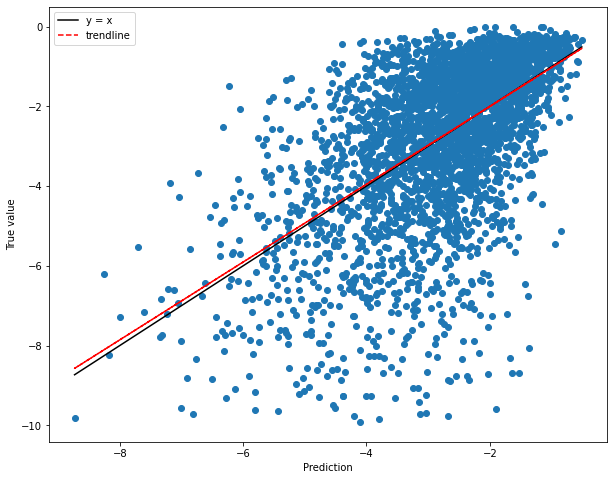

In [33]:
plot_predict(reg.predict(X_test), y_test)

# Random forest with hyperparams

In [34]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    import seaborn as sns
    
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    
    return fig

In [35]:
param_grid = {
    'bootstrap': [True, False],
    # 'max_depth': [2, 3, 4], 
    # 'min_samples_leaf': [2, 3, 4],
    # 'min_samples_split': [5, 6, 7, 8],
    'n_estimators': [100, 150, 200, 250]
}

In [36]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=6, n_jobs=-1, verbose=3)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  48 | elapsed:   26.0s remaining: 10.0min
[Parallel(n_jobs=-1)]: Done  19 out of  48 | elapsed:   55.2s remaining:  1.4min


In [157]:
mean_squared_error(y_test, grid_search.predict(X_test))

2.6237809832292123

# One Hot Encoding

In [34]:
X = df_store_sku[['ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity', 'Q1_Qty', 'Q1_Price', 'Q1_Elasticity', 'Q1_Ttest']]
y = df_store_sku['Elasticity']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [37]:
categorical = ['ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity']

In [38]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('random-forest', RandomForestRegressor())
])

model = pipeline.fit(X_train, y_train)

In [39]:
mean_squared_error(y_test, model.predict(X_test))

3.80072742610383

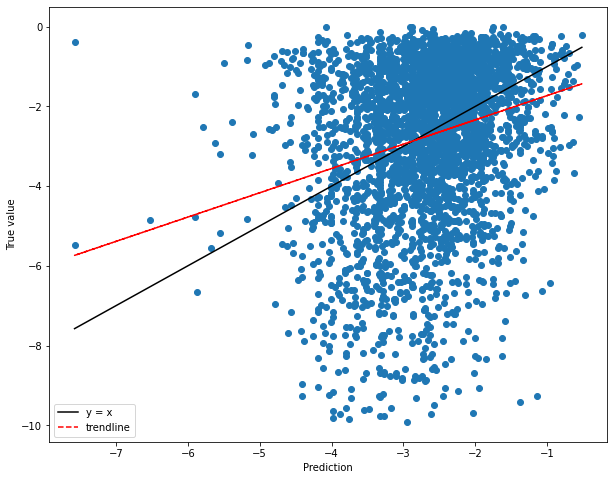

In [40]:
plot_predict(model.predict(X_test), y_test)

# PED on 2019Q1

In [41]:
mean_squared_error(y_test, X_test.Q1_Elasticity)

7.758294444974354

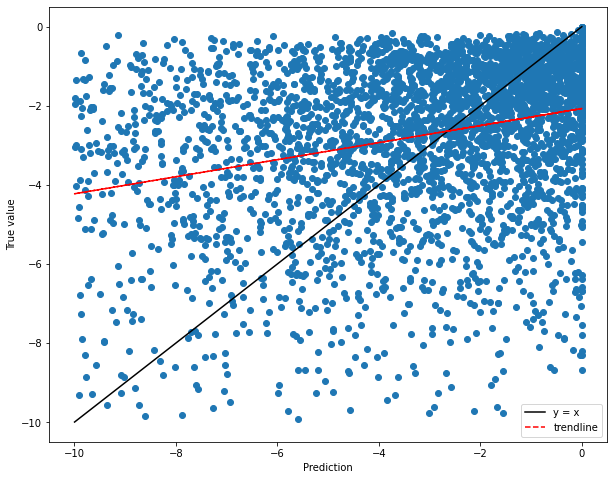

In [42]:
plot_predict(X_test.Q1_Elasticity, y_test)

# Composition (mean)

In [43]:
pred_random_forest = reg.predict(X_test)
pred_ped_q1 = X_test.Q1_Elasticity

In [44]:
pred_compo = (pred_random_forest + pred_ped_q1) / 2.0

In [45]:
mean_squared_error(pred_compo, y_test)

3.850409657977593

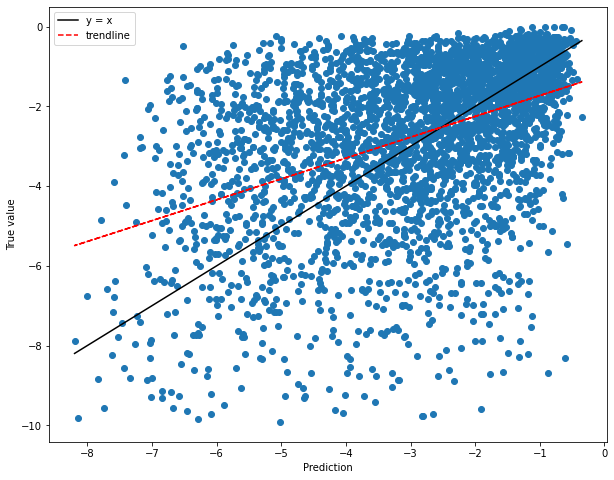

In [46]:
plot_predict(pred_compo, y_test)

# Composition (weighted mean)

In [120]:
from sklearn.linear_model import LinearRegression

In [121]:
def make_compo_train(data):
    return np.concatenate(
        (
            reg.predict(data).reshape((len(data), 1)),
            data.Q1_Elasticity.to_numpy().reshape((len(data), 1))
        ),
        axis=1
    )

In [122]:
linear_model = LinearRegression().fit(make_compo_train(X_train), y_train.to_numpy())

In [123]:
mean_squared_error(y_test, linear_model.predict(make_compo_train(X_test)))

2.764195114837197

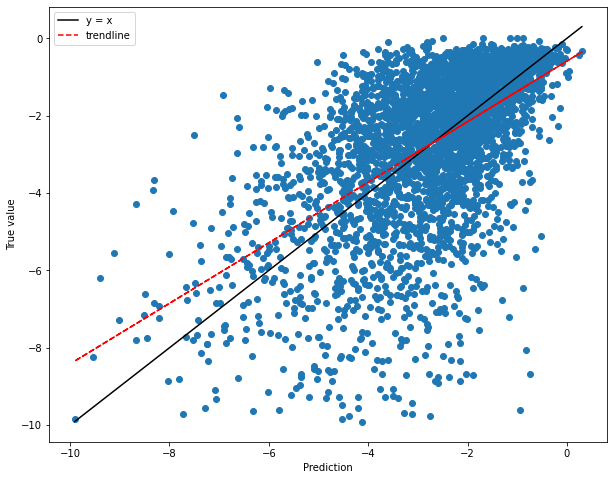

In [124]:
plot_predict(linear_model.predict(make_compo_train(X_test)), y_test)